# CLASSIFICATION TASK: FRAUD DETECTION

The pyhton file is divided into three sections:
- models on the original dataset
- models on the original dataset with grouped Shuffle split
- models on the grouped dataset

## IMPORTING THE LIBRARIES 

In [4]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import yellowbrick
import shap
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, r2_score
import xgboost as xgb
import vaex.ml
import datetime as dt

In [5]:
pd.set_option('display.max_columns',None)

## CLASSIFICATION ON THE ORIGINAL DATASET

#### IMPORTING THE DATASET


In [7]:
df = pd.read_csv('SupplyChainDataset.csv')

#### DATASET CLEANING AND PREPROCESSING 

These are steps used for the data cleaning and data preprocessing.

In [8]:
#Transforming the order date in date time format
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])

In [9]:
#calculating the recency column
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

df['InvoiceMonth'] = df['order date (DateOrders)'].apply(get_month)
grouping = df.groupby('Customer Id')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
grouping_days = df.groupby('Customer Id')['order date (DateOrders)']
df['Cohortdays']  = grouping_days.transform('min')
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    date = df[column].dt.date
    hour = df[column].dt.hour
    return year, month, date, hour

Invoice_Year, Invoice_Month, Invoice_Day, _ = get_date_int(df, 'order date (DateOrders)')
Cohort_Year, Cohort_Month , Cohort_day, _ = get_date_int(df, 'Cohortdays')
Year_Diff = Invoice_Year - Cohort_Year
Month_Diff = Invoice_Month - Cohort_Month
Day_Diff = Invoice_Day - Cohort_day
df['CohortIndex_months'] = Year_Diff*12 + Month_Diff +1
df['CohortIndex_days'] = Day_Diff.dt.days

In [10]:
#creating one class that add the target variable,parsing column names, removing unneccesary colums, augmenting the dataframe with new features
class PreprocessDataFrame:
    def __init__(self, df):
        self.df = df

    def add_target_variable(self):
        self.df['Is_Fraud'] = self.df['Order Status'].apply(lambda x: 1 if x=='SUSPECTED_FRAUD' else 0)
        return self.df

    def parse_column_names(self):
        self.df.columns = [i.replace(' ','_').replace('(','').replace(')','') for i in self.df.columns]
        return self.df

    def drop_unuseful_columns(self):
        to_drop = ['Customer_Country', 'Customer_Email', 'Customer_Fname',
                  'Customer_Lname', 'Customer_Password', 'Customer_Street', 
                   'Customer_Zipcode','Product_Description', 'Product_Image', 
                   'Product_Status', 'Order_Zipcode', 'Order_Item_Id',
                  'Order_Country', 'Order_Customer_Id', 'Order_Country', 
                   'Order_Region', 'Order_State','Market', 
                   'Customer_State', 'Order_Item_Cardprod_Id', 'Product_Card_Id',
                  'Benefit_per_order','Product_Price', 'Days_for_shipping_real', 
                   'Late_delivery_risk', 'Delivery_Status', 'Order_Status',
                   'shipping_date_DateOrders']

        self.df['Category_Department_Name'] = (self.df['Category_Name'] + '_' + self.df['Department_Name']) \
          .str.replace(' ', '_')

        self.df = self.df.drop(to_drop + ['Category_Name','Department_Name'], axis=1)
        return self.df
  

    def total_items_per_order(self):
        self.df['Total_Items_In_The_Cart']  = self.df['Order_Id'].map(self.df['Order_Id'].value_counts().to_dict())
        return self.df


    def process_datetetimes(self):
        self.df.order_date_DateOrders = pd.to_datetime(self.df.order_date_DateOrders)
        (self.df.order_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')
        return self.df

    def augment_with_network_features(self):
        self.df['Source'] = ('LA' + self.df['Latitude'].astype('str') + '-' + 'LO' + self.df['Longitude'].astype('str'))
        G = nx.from_pandas_edgelist(self.df, source='Source', target='Order_City')
        self.df['Source_Centrality'] = self.df.Source.map(dict(G.degree))
        return self.df


preprocessor = PreprocessDataFrame(df).add_target_variable()
preprocessor = PreprocessDataFrame(preprocessor).parse_column_names()
preprocessor = PreprocessDataFrame(preprocessor).drop_unuseful_columns()
preprocessor = PreprocessDataFrame(preprocessor).total_items_per_order()
preprocessor = PreprocessDataFrame(preprocessor).process_datetetimes()
preprocessor = PreprocessDataFrame(preprocessor).augment_with_network_features()
preprocessor['Customer_Id'] = preprocessor['Customer_Id'].astype('object')
preprocessor['total_number_of_transactions_so_far'] = preprocessor.groupby('Customer_Id').cumcount() + 1

In [11]:
#creating another clss that apply the vaex CycleTrasformer, do the train-test split and encode the categorical variables 
class ClassificationDataframeProcessor:

    def __init__(self):
        self.columns_for_ml = ['Customer_City', 'Days_for_shipment_scheduled',
       'Sales_per_customer', 'Customer_Segment', 'Latitude', 'total_number_of_transactions_so_far',
       'Longitude', 'Order_City', 'Order_Item_Quantity',
       'Shipping_Mode', 'Type', 'CohortIndex_months', 'CohortIndex_days', 'Source_Centrality',
        'Order_Month', 'Order_Day', 'Order_Weekday', 'Is_Fraud', "Category_Id", 'Department_Id']

    def process_df_for_classification(self, df):
        
        df['order_date_DateOrders'] = pd.to_datetime(df['order_date_DateOrders'], unit='ms')

        df['Order_Month'] = df.order_date_DateOrders.dt.month
        df['Order_Day'] = df.order_date_DateOrders.dt.day
        df['Order_Weekday'] = df.order_date_DateOrders.dt.dayofweek

        ml = df[self.columns_for_ml]
        return ml

    def cycletransform_month_day_weekday(self,df):
        """
        
        """
        ml = vaex.from_pandas(df=df, copy_index=False)
        ml = vaex.ml.CycleTransformer(features=['Order_Month'], n=12).fit_transform(ml)
        ml = vaex.ml.CycleTransformer(features=['Order_Day'], n=31).fit_transform(ml)
        ml = vaex.ml.CycleTransformer(features=['Order_Weekday'], n=7).fit_transform(ml)
        ml = ml.to_pandas_df()
        return ml

    def return_processed_and_split_X_y(self,df):
        X = df[[i for i in df.columns if i != 'Is_Fraud']]
        X = X.drop(['Order_Month','Order_Day','Order_Weekday'],axis=1)
        y = df['Is_Fraud']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
        return X_train, X_test, y_train, y_test

    @staticmethod
    def encode_Xtrain_Xtest(X_train,X_test):

        X_train = vaex.from_pandas(df=X_train, copy_index=False)
        X_test = vaex.from_pandas(df=X_test, copy_index=False)
        ohe = vaex.ml.OneHotEncoder(features=['Type', "Customer_Segment",'Shipping_Mode'])
        X_train = ohe.fit_transform(df=X_train)
        X_test = ohe.transform(X_test)

        mhe = vaex.ml.MultiHotEncoder(features=["Order_City", "Category_Id", 'Department_Id'])
        X_train = mhe.fit_transform(df=X_train)
        X_test = mhe.transform(X_test)

        X_train = X_train.to_pandas_df()
        X_test = X_test.to_pandas_df()

        X_train = X_train[X_train.dtypes[X_train.dtypes != 'object'].index.tolist()]
        X_test = X_test[X_test.dtypes[X_test.dtypes != 'object'].index.tolist()]

        return X_train, X_test

cdp = ClassificationDataframeProcessor()
df_class = cdp.process_df_for_classification(preprocessor)
df_class = cdp.cycletransform_month_day_weekday(df_class)
X_train, X_test, y_train, y_test = cdp.return_processed_and_split_X_y(df_class)
X_train, X_test = cdp.encode_Xtrain_Xtest(X_train, X_test)

### MODELS

#### BASELINE MODELS

In [12]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

#### LOGISTIC REGRESSION

In [ ]:
#Try Logisitc Regression with Matthew Corr Coeff as Scoring Params
numeric_pipeline = Pipeline(steps = [
    ('minmax', MinMaxScaler())])

full_processor = ColumnTransformer([
     ('number', numeric_pipeline, numerical_features)])
     
log = LogisticRegression(random_state=42, max_iter = 1000, class_weight = 'balanced')

# set up pipeline
log_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', log)])

params = {"model__solver": ["newton-cg", "saga", "lbfgs"],
         "model__C": np.linspace(0.001, 1.0, 10)}
#Random Search for Logistc Regression
search = GridSearchCV(log_pipeline, param_grid=params, scoring='matthews_corrcoef', n_jobs=-1)

_=search.fit(X_train, y_train)

In [ ]:
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred))
print("Matthews_corrcoef:",matthews_corrcoef(y_test, y_pred))

In [ ]:
#confusion matrix
from sklearn import metrics
# MAKE FIGURE
fig, axes = plt.subplots(figsize=(10,4),ncols=2)

# PLOTTING CONFUSION MATRIX 
metrics.ConfusionMatrixDisplay.from_estimator(search, X_test,y_test,
                              display_labels=None,
                              normalize='true',
                             cmap='Blues',ax=axes[0])
axes[0].set(title='Confusion Matrix')

#PLOTTING ROC CURVE
roc_plot = metrics.RocCurveDisplay.from_estimator(svm_pipeline, X_test, y_test,ax=axes[1])
axes[1].legend()
axes[1].plot([0,1],[0,1],ls=':')
axes[1].grid()
axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
fig.tight_layout()
plt.show()

#### SVM CLASSIFIER

In [ ]:
from sklearn import svm
num_pipeline = Pipeline([
        ('minmax', MinMaxScaler())])

full_processor = ColumnTransformer([
        ("num_pipeline", num_pipeline, numerical_features)
    ])
class_weights = round(y_train.value_counts()[0] / y_train.value_counts()[1])

svm = svm.SVC(kernel='rbf')
svm_pipeline = Pipeline([
    ('preprocess', full_processor),
    ('fit', svm)])

_=svm_pipeline.fit(X_train, y_train)
y_pred = svm_pipeline.predict(X_test)

In [ ]:
y_pred = svm_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     58232
           1       0.00      0.00      0.00      1340

    accuracy                           0.98     59572
   macro avg       0.49      0.50      0.49     59572
weighted avg       0.96      0.98      0.97     59572



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


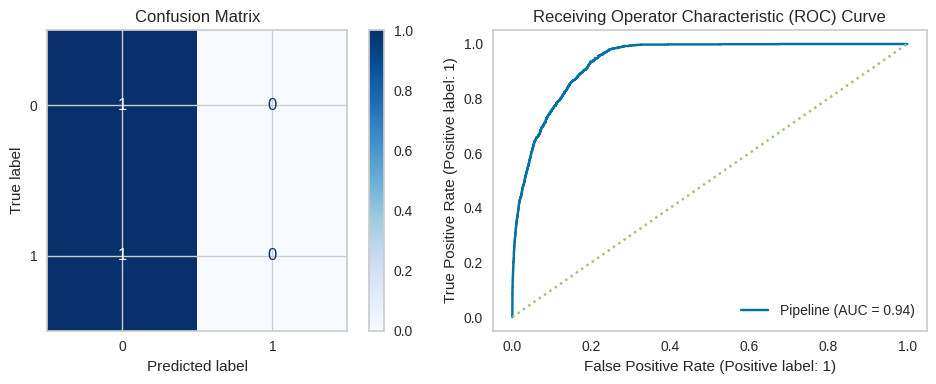

In [ ]:
from sklearn import metrics
# MAKE FIGURE
fig, axes = plt.subplots(figsize=(10,4),ncols=2)

# PLOTTING CONFUSION MATRIX 
metrics.ConfusionMatrixDisplay.from_estimator(svm_pipeline, X_test,y_test,
                              display_labels=None,
                              normalize='true',
                             cmap='Blues',ax=axes[0])
axes[0].set(title='Confusion Matrix')

#PLOTTING ROC CURVE
roc_plot = metrics.RocCurveDisplay.from_estimator(svm_pipeline, X_test, y_test,ax=axes[1])
axes[1].legend()
axes[1].plot([0,1],[0,1],ls=':')
axes[1].grid()
axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
fig.tight_layout()
plt.show()

#### XGBOOST CLASSIFIER  FOR UNBALANCED DATA

In [ ]:
class_weights = round(y_train.value_counts()[0] / y_train.value_counts()[1])

#from sklearn.model_selection import StratifiedKFold
xgb_c = xgb.XGBClassifier(eval_metric='auc', 
                          objective='binary:logistic',
                          n_estimators=800,
                          scale_pos_weight=class_weights,
                          colsample_bytree = 1,
                          gamma = 0,
                          learning_rate = 0.3,
                          max_depth = 12,
                          min_child_weight = 1)

_=xgb_c.fit(X_train, y_train)
y_pred_base = xgb_c.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     58232
           1       0.97      0.77      0.86      1340

    accuracy                           0.99     59572
   macro avg       0.98      0.88      0.93     59572
weighted avg       0.99      0.99      0.99     59572



In [ ]:
explainer = shap.TreeExplainer(xgb_c)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


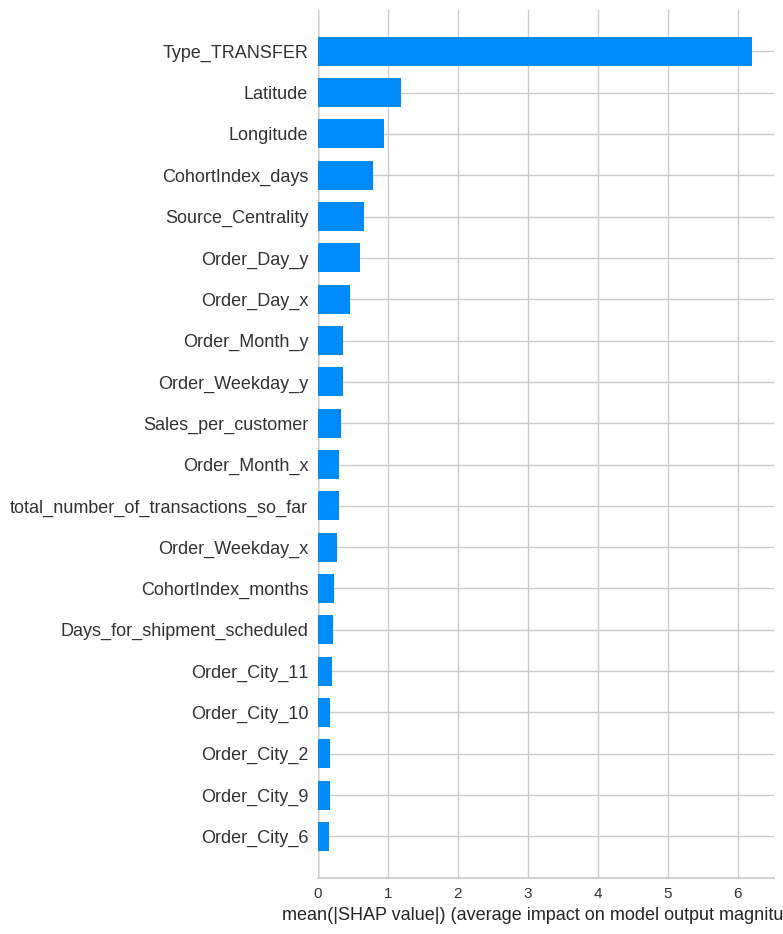

In [ ]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type='bar')

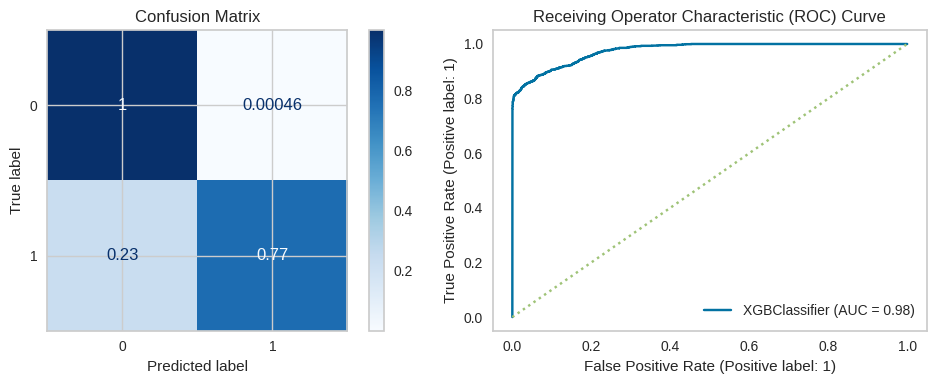

In [ ]:
from sklearn import metrics
# MAKE FIGURE
fig, axes = plt.subplots(figsize=(10,4),ncols=2)

# PLOTTING CONFUSION MATRIX 
metrics.ConfusionMatrixDisplay.from_estimator(xgb_c, X_test,y_test,
                              display_labels=None,
                              normalize='true',
                             cmap='Blues',ax=axes[0])
axes[0].set(title='Confusion Matrix')

#PLOTTING ROC CURVE
roc_plot = metrics.RocCurveDisplay.from_estimator(xgb_c, X_test, y_test,ax=axes[1])
axes[1].legend()
axes[1].plot([0,1],[0,1],ls=':')
axes[1].grid()
axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
fig.tight_layout()
plt.show()

##### MODEL OPTIMIZATION WITH BAYESIAN METHOD

In [ ]:
#define the object function for the bayesian optimizer
def xgb_cv(max_depth, n_estimators, learning_rate, subsample, colsample_bytree):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree
    }
    
    clf = xgb.XGBClassifier(**params)
    
    cv_result = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
    
    return cv_result.mean()

class_weights = len(y_train) / (2 * np.bincount(y_train))

#define the space for the bayesian optimizer
pbounds = {
    'max_depth': (3, 9),
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1)
}

xgb_bo = BayesianOptimization(f=xgb_cv, pbounds=pbounds, verbose=2, random_state=42)
xgb_bo.maximize()

best_params = xgb_bo.max['params']

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': int(best_params['max_depth']),
    'n_estimators': int(best_params['n_estimators']),
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree']
}


In [ ]:
params = {'colsample_bytree': 0.7806204848436595,
 'learning_rate': 0.3613362625590517,
 'max_depth': int(7.7185207148613655),
 'n_estimators': int(640.933693904489),
 'subsample': 0.9986912749518453}
model_bayes = xgb.XGBClassifier(**params)
_=model_bayes.fit(X_train, y_train)
y_pred =model_bayes.predict(X_test)

In [ ]:
#this model increased the precision but didn't manage to outperfom the recall of the above model. Therefore, we have decided to 
#save the first xgboost model. However, it was a nice try. 
print('This is the classification report for the base model of XGBoost: ')
print(classification_report(y_test, y_pred))

This is the classification report for the base model of XGBoost: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     58232
           1       0.99      0.64      0.78      1340

    accuracy                           0.99     59572
   macro avg       0.99      0.82      0.89     59572
weighted avg       0.99      0.99      0.99     59572



## Classification on Stratified Grouped ID

CLEANING THE DATASET AND PREPROCESSING IT AS WE DID ON THE ORIGINAL DATASET.

In [ ]:
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])

In [ ]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

df['InvoiceMonth'] = df['order date (DateOrders)'].apply(get_month)
grouping = df.groupby('Customer Id')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
grouping_days = df.groupby('Customer Id')['order date (DateOrders)']
df['Cohortdays']  = grouping_days.transform('min')
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    date = df[column].dt.date
    hour = df[column].dt.hour
    return year, month, date, hour

Invoice_Year, Invoice_Month, Invoice_Day, _ = get_date_int(df, 'order date (DateOrders)')
Cohort_Year, Cohort_Month , Cohort_day, _ = get_date_int(df, 'Cohortdays')
Year_Diff = Invoice_Year - Cohort_Year
Month_Diff = Invoice_Month - Cohort_Month
Day_Diff = Invoice_Day - Cohort_day
df['CohortIndex_months'] = Year_Diff*12 + Month_Diff +1
df['CohortIndex_days'] = Day_Diff.dt.days

In [ ]:
class PreprocessDataFrame:
    def __init__(self, df):
        self.df = df

    def add_target_variable(self):
        self.df['Is_Fraud'] = self.df['Order Status'].apply(lambda x: 1 if x=='SUSPECTED_FRAUD' else 0)
        return self.df

    def parse_column_names(self):
        self.df.columns = [i.replace(' ','_').replace('(','').replace(')','') for i in self.df.columns]
        return self.df

    def drop_unuseful_columns(self):
        to_drop = ['Customer_Country', 'Customer_Email', 'Customer_Fname', 'Customer_Id',
                   'Customer_Lname', 'Customer_Password', 'Customer_Street', 'Customer_Zipcode',
                   'Product_Description', 'Product_Image', 'Product_Status', 'Order_Zipcode', 'Order_Item_Id',
                   'Order_Country', 'Order_Customer_Id', 'Order_Country', 'Order_Region', 'Order_State',
                   'Market', 'Customer_State', 'Order_Item_Cardprod_Id', 'Product_Card_Id',
                   'Order_Profit_Per_Order','Department_Id','Product_Price']

        self.df['Category_Department_Name'] = (self.df['Category_Name'] + '_' + self.df['Department_Name']) \
            .str.replace(' ', '_')

        self.df = self.df.drop(to_drop + ['Category_Name','Department_Name'], axis=1)
        return self.df

    def process_datetetimes(self):
        self.df.shipping_date_DateOrders = pd.to_datetime(self.df.shipping_date_DateOrders)
        (self.df.shipping_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')

        self.df.order_date_DateOrders = pd.to_datetime(self.df.order_date_DateOrders)
        (self.df.order_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')
        return self.df

    def augment_with_network_features(self):
        self.df['Source'] = ('LA' + self.df['Latitude'].astype('str') + '-' + 'LO' + self.df['Longitude'].astype('str'))
        G = nx.from_pandas_edgelist(self.df, source='Source', target='Order_City')
        self.df['Source_Centrality'] = self.df.Source.map(dict(G.degree))
        return self.df

THIS CLASS CONTRARY TO THE ONE IN THE ORIGINAL DATASET HAS THE GROUP SHUFFLE TRAIN-TEST SPLIT WHICH ALLOWS TO KEEP ALL THE ITEMS OF THE SAME ORDER TOGHETER DURING THE SPLIT

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
class ClassificationDataframeProcessor:
    #drop columns to avoid collinerarity. We do so on the basis of the corr matrix showed in the EDA repository
    def __init__(self):
        self.columns_for_ml = ['Days_for_shipment_scheduled','Benefit_per_order',
                               'Order_Id', 'Customer_City',
                               'Customer_Segment','Latitude','Longitude','Order_City',
                               'Order_Item_Discount','Order_Item_Discount_Rate', 'Type',
                               'Order_Item_Profit_Ratio','Order_Item_Quantity',
                               'Sales', 'Product_Name',
                               'Shipping_Mode','Category_Id','Source_Centrality',
                               'Order_Month','Order_Day','Order_Weekday','Is_Fraud']

    def process_df_for_classification(self, df):
        df['shipping_date_DateOrders'] = pd.to_datetime(df['shipping_date_DateOrders'], unit='ms')
        df['order_date_DateOrders'] = pd.to_datetime(df['order_date_DateOrders'], unit='ms')

        df['Order_Month'] = df.order_date_DateOrders.dt.month
        df['Order_Day'] = df.order_date_DateOrders.dt.day
        df['Order_Weekday'] = df.order_date_DateOrders.dt.dayofweek

        ml = df[self.columns_for_ml]
        return ml

    def cycletransform_month_day_weekday(self,df):
        """
        
        """
        ml = vaex.from_pandas(df=df, copy_index=False)
        ml = vaex.ml.CycleTransformer(features=['Order_Month'], n=12).fit_transform(ml)
        ml = vaex.ml.CycleTransformer(features=['Order_Day'], n=31).fit_transform(ml)
        ml = vaex.ml.CycleTransformer(features=['Order_Weekday'], n=7).fit_transform(ml)
        ml = ml.to_pandas_df()
        return ml

    def return_processed_and_split_X_y(self, df):
        X = df[[i for i in df.columns if i != 'Is_Fraud']]
        X = X.drop(['Order_Month', 'Order_Day', 'Order_Weekday'], axis=1)
        y = df['Is_Fraud']
        
        #GroupShuffleSplit
        
        groups = df['Order_Id'] 
        splitter = GroupShuffleSplit(n_splits=2, test_size=0.33)
        train_idx, test_idx = next(splitter.split(X, y, groups))

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train = X_train.drop('Order_Id', axis=1)
        X_test = X_test.drop('Order_Id', axis=1)

        return X_train, X_test, y_train, y_test

    @staticmethod
    def encode_Xtrain_Xtest(X_train,X_test):

        X_train = vaex.from_pandas(df=X_train, copy_index=False)
        X_test = vaex.from_pandas(df=X_test, copy_index=False)
        ohe = vaex.ml.OneHotEncoder(features=["Type", "Customer_Segment",'Shipping_Mode'])
        X_train = ohe.fit_transform(df=X_train)
        X_test = ohe.transform(X_test)

        mhe = vaex.ml.MultiHotEncoder(features=["Order_City", "Category_Id", 'Customer_City'])
        X_train = mhe.fit_transform(df=X_train)
        X_test = mhe.transform(X_test)

        X_train = X_train.to_pandas_df()
        X_test = X_test.to_pandas_df()

        X_train = X_train[X_train.dtypes[X_train.dtypes != 'object'].index.tolist()]
        X_test = X_test[X_test.dtypes[X_test.dtypes != 'object'].index.tolist()]

        return X_train, X_test

#read the original data
df_original = pd.read_csv('SupplyChainDataset.csv')
#apply the PreprocessDataFrame class and its related functions. 
#preprocessor = PreprocessDataFrame(df_original)
preprocessor = PreprocessDataFrame(df_original).add_target_variable()
preprocessor = PreprocessDataFrame(preprocessor).parse_column_names()
preprocessor = PreprocessDataFrame(preprocessor).drop_unuseful_columns()
preprocessor = PreprocessDataFrame(preprocessor).process_datetetimes()
preprocessor = PreprocessDataFrame(preprocessor).augment_with_network_features()  #This class add the 'Source_Centrality' measure, which rely on networkz built-in function to compute the 
#importance of the source (the Stores, as identified by their lat and long features') on the targets (the order cities). 

#apply the class for the dataframe processor for the models
cdp = ClassificationDataframeProcessor()
df_class = cdp.process_df_for_classification(preprocessor)
df_class = cdp.cycletransform_month_day_weekday(df_class)
X_train, X_test, y_train, y_test = cdp.return_processed_and_split_X_y(df_class)
X_train, X_test = cdp.encode_Xtrain_Xtest(X_train, X_test)

#### XGBOOST CLASSIFIER ON THE STRATIFIED GROUPED ID

In [ ]:
class_weights = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])
from xgboost import XGBClassifier
xgb= XGBClassifier(objective = 'binary:logistic', scale_pos_weight=class_weights)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     58336
           1       0.10      0.05      0.07      1328

    accuracy                           0.97     59664
   macro avg       0.54      0.52      0.53     59664
weighted avg       0.96      0.97      0.96     59664



The result obtained with the new method of splitting the train and test set did not improve a lot the performance of the models on the grouped models. Running different times this model with the Group Shuffle split provided us quite different results, probably depending on the ramdomness of the Group Shuffle Split. 

### XGBoost Tuning with Bayes Opt

In [ ]:
from bayes_opt import BayesianOptimization

class_weights = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])
#define the object function for the bayesian optimizer
def xgb_cv(max_depth, n_estimators, learning_rate, subsample, colsample_bytree):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'scale_pos_weight': class_weights
    }
    
    clf = XGBClassifier(**params)
    
    cv_result = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
    
    return cv_result.mean()

#define the space for the bayesian optimizer
pbounds = {
    'max_depth': (3, 9),
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1)
}

xgb_bo = BayesianOptimization(f=xgb_cv, pbounds=pbounds, verbose=2, random_state=42)
xgb_bo.maximize()

best_params = xgb_bo.max['params']

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'max_depth': int(best_params['max_depth']),
    'n_estimators': int(best_params['n_estimators']),
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'scale_pos_weight': class_weights    
}

print(best_params)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.8498    | 0.4371    | 0.4759    | 7.392     | 638.8     | 0.2404    |
| 2         | 0.8993    | 0.2404    | 0.03846   | 8.197     | 641.0     | 0.7373    |
| 3         | 0.872     | 0.1185    | 0.4853    | 7.995     | 291.1     | 0.2636    |
| 4         | 0.8957    | 0.2651    | 0.1591    | 6.149     | 488.8     | 0.3621    |
| 5         | 0.8712    | 0.6507    | 0.07835   | 4.753     | 429.7     | 0.5105    |
| 6         | 0.899     | 0.839     | 0.2516    | 8.081     | 640.7     | 0.7136    |
| 7         | 0.904     | 0.5357    | 0.2838    | 7.599     | 641.9     | 0.8703    |
| 8         | 0.9019    | 0.1178    | 0.4263    | 8.74      | 643.0     | 0.9       |
| 9         | 0.8808    | 0.8853    | 0.4487    | 6.986     | 644.7     | 0.5658    |
| 10        | 0.8668    | 0.8259    | 0.4374    | 3.66

In [ ]:
# We have tunend the xgboos classifier to verify the results of the New grouping techniques. However, after a careful review of the grouping techniques and the models, we have realised that even this approach does not allow for a significative improvement of the results.
params = { 'objective': 'binary:logistic', 'eval_metric': 'aucpr','colsample_bytree': 0.5772519617065073, 'learning_rate': 0.1378604524263592, 'max_depth': int(8.289678195863338), 'n_estimators': int(640.3408512170186), 'subsample': 0.9828401240627447}

class_weights = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])
from xgboost import XGBClassifier
xgb_bopt= XGBClassifier(**params, scale_pos_weight=class_weights )
xgb_bopt.fit(X_train, y_train)

y_pred_martino = xgb_bopt.predict(X_test)
print(classification_report(y_test, y_pred_martino))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     58529
           1       0.09      0.00      0.01      1372

    accuracy                           0.98     59901
   macro avg       0.53      0.50      0.50     59901
weighted avg       0.96      0.98      0.97     59901



In [ ]:
explainer = shap.TreeExplainer(xgb_bopt)
shap_values = explainer.shap_values(X_test)

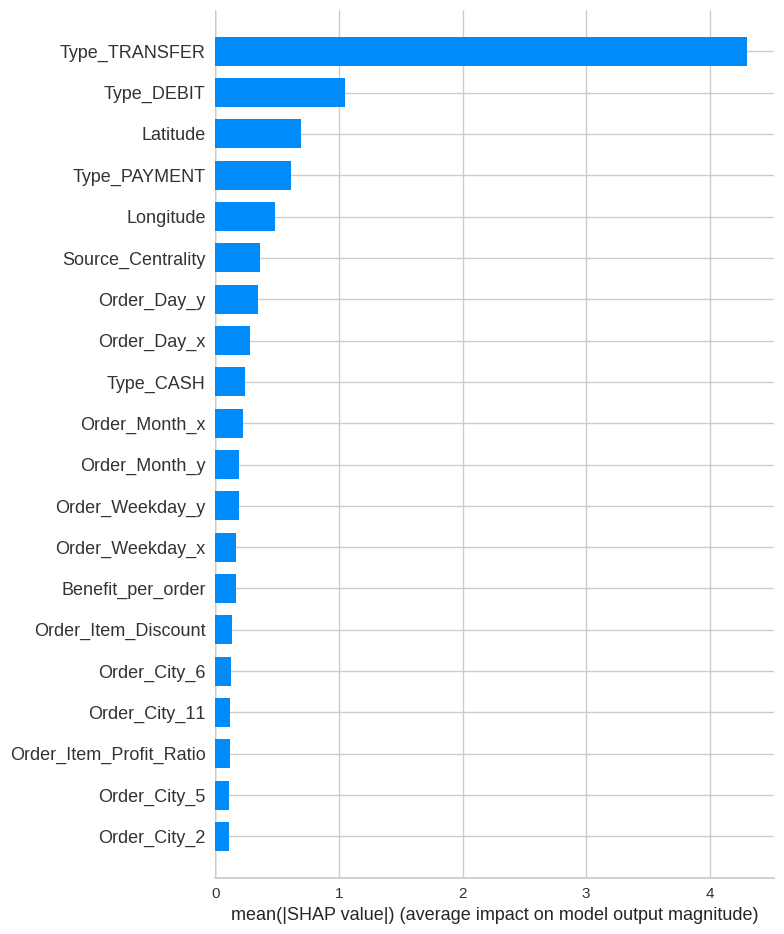

In [ ]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type ='bar', show=False)
plt.savefig('shap_plot_stratified_orderid')

## CLASSIFICATION ON THE GROUPED DATASET

### Methodology for grouping

In [ ]:
# Trasforming the original dataframe into the grouped dataframe 

agg_functions = {
    'Type': 'first',
    'Order Status': 'first',
    'Order City': 'first',
    'Customer City':'first',
    'Order State': 'first',
    'Customer State':'first',
    'Delivery Status': 'first',
    'Shipping Mode':'first',
    'Days for shipping (real)': 'first',
    'Days for shipment (scheduled)' :'first',
    'order date (DateOrders)': 'first',
    'Benefit per order': ['sum', 'median'],
    'Order Item Discount Rate': 'median',
    'Customer Segment': 'first',
    'Customer Id': 'first',
    'Latitude': 'first',
    'Longitude': 'first',
    #'Category Id': lambda x: ','.join(x.unique()),
    'Category Name': lambda x: ','.join(x.unique()),
    # Add the rest of the categorical columns with the lambda function
    'Order Item Total': ['sum',"median"],
    'Order Item Quantity': ['sum']
    # Add any additional numerical columns with the appropriate aggregation functions
}
# Group by 'Order Id' and apply the aggregation functions
grouped_df = df.groupby('Order Id').agg(agg_functions).reset_index()
grouped_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in grouped_df.columns]
grouped_df = grouped_df.drop(columns=["Order Id_"], axis=1)

### DATA PREPROCESSING

In [ ]:
import datetime as dt
grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

grouped_df['InvoiceMonth'] = grouped_df['order date (DateOrders)_first'].apply(get_month)
grouping = grouped_df.groupby('Customer Id_first')['InvoiceMonth']
grouped_df['CohortMonth'] = grouping.transform('min')
grouping_days = grouped_df.groupby('Customer Id_first')['order date (DateOrders)_first']
grouped_df['Cohortdays']  = grouping_days.transform('min')
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    date = df[column].dt.date
    hour = df[column].dt.hour
    return year, month, date, hour

Invoice_Year, Invoice_Month, Invoice_Day, _ = get_date_int(grouped_df, 'order date (DateOrders)_first')
Cohort_Year, Cohort_Month , Cohort_day, _ = get_date_int(grouped_df, 'Cohortdays')
Year_Diff = Invoice_Year - Cohort_Year
Month_Diff = Invoice_Month - Cohort_Month
Day_Diff = Invoice_Day - Cohort_day
grouped_df['CohortIndex_months'] = Year_Diff*12 + Month_Diff +1
grouped_df['CohortIndex_days'] = Day_Diff.dt.days

import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Assuming you have a DataFrame named 'grouped_data' with a column 'Category Name' containing comma-separated values
# Convert the comma-separated strings to lists
grouped_df['Category Name_<lambda>'] = grouped_df['Category Name_<lambda>'].apply(lambda x: x.split(','))

from sklearn.preprocessing import MultiLabelBinarizer
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the 'Category Name' column
category_name_encoded = mlb.fit_transform(grouped_df['Category Name_<lambda>'])

# Create a new DataFrame with binary features for each unique item in 'Category Name'
category_name_df = pd.DataFrame(category_name_encoded, columns=mlb.classes_)

# Combine the new binary features with the original DataFrame
grouped_df = pd.concat([grouped_df.drop(columns=['Category Name_<lambda>']), category_name_df], axis=1)

grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])
grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'], unit='ms')
grouped_df['Order_Month'] = grouped_df['order date (DateOrders)_first'].dt.month
grouped_df['Order_Day'] =grouped_df['order date (DateOrders)_first'].dt.day
grouped_df['Order_Weekday'] = grouped_df['order date (DateOrders)_first'].dt.dayofweek

grouped_df = vaex.from_pandas(df=grouped_df, copy_index=False)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Month'], n=12).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Day'], n=31).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Weekday'], n=7).fit_transform(grouped_df)
grouped_df = grouped_df.to_pandas_df()

In [ ]:
class PreprocessDataFrame_classification:
    def __init__(self, df):
        self.df = df

    def add_target_variable(self):
        self.df['Is_Fraud'] = self.df['Order Status_first'].apply(lambda x: 1 if x=='SUSPECTED_FRAUD' else 0)
        return self.df
    
    def drop_canceled(self):
        self.df = self.df[self.df['Order Status_first'] != 'CANCELED']
        return self.df
  
  #def cumulative_orders_customer(self):
     # self.df['Customer_Id'] = self.df['Customer_Id'].astype('object')
      #self.df['total_number_of_transactions_so_far'] = self.df.groupby('Customer_Id').cumcount() + 1

    def process_datetetimes(self):
        self.df.order_date_DateOrders = pd.to_datetime(self.df.order_date_DateOrders)
        (self.df.order_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')
        return self.df

    def augment_with_network_features(self):
        self.df['Source'] = ('LA' + self.df['Latitude_first'].astype('str') + '-' + 'LO' + self.df['Longitude_first'].astype('str'))
        G = nx.from_pandas_edgelist(self.df, source='Source', target='Order City_first')
        self.df['Source_Centrality'] = self.df.Source.map(dict(G.degree))
        return self.df

grouped_df = PreprocessDataFrame_classification(grouped_df).add_target_variable()
grouped_df = PreprocessDataFrame_classification(grouped_df).drop_canceled()
grouped_df = PreprocessDataFrame_classification(grouped_df).augment_with_network_features()
grouped_df = grouped_df.drop('Order Status_first', axis=1)
    
X = grouped_df[[i for i in grouped_df.columns if i != 'Is_Fraud']]
X = grouped_df.drop(['Order_Month','Order_Day','Order_Weekday', 'order date (DateOrders)_first', 'InvoiceMonth',
                    'CohortMonth', 'Cohortdays', 'Is_Fraud', 'Customer Id_first', 'Delivery Status_first', "Days for shipping (real)_first"],axis=1)

y = grouped_df['Is_Fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

X_train = vaex.from_pandas(df=X_train, copy_index=False)
X_test = vaex.from_pandas(df=X_test, copy_index=False)
ohe = vaex.ml.OneHotEncoder(features=["Type_first", 
                                      "Customer Segment_first",'Shipping Mode_first'])
X_train = ohe.fit_transform(df=X_train)
X_test = ohe.transform(X_test)

mhe = vaex.ml.MultiHotEncoder(features=["Order City_first", "Customer City_first", 'Order State_first', 'Customer State_first'])
X_train = mhe.fit_transform(df=X_train)
X_test = mhe.transform(X_test)

X_train = X_train.to_pandas_df()
X_test = X_test.to_pandas_df()

X_train = X_train[X_train.dtypes[X_train.dtypes != 'object'].index.tolist()]
X_test = X_test[X_test.dtypes[X_test.dtypes != 'object'].index.tolist()]

### MODELS

#### BASELINE MODEL

In [ ]:
#logisitc regression 
#Try Logisitc Regression with Matthew Corr Coeff as Scoring Params
numerical_features = X_train.select_dtypes(include='number').columns.tolist()

numeric_pipeline = Pipeline(steps = [
    ('minmax', MinMaxScaler())])

full_processor = ColumnTransformer([
     ('number', numeric_pipeline, numerical_features)])
     
log = LogisticRegression(random_state=42, max_iter = 1000, class_weight = 'balanced')

# set up pipeline
log_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', log)])

params = {"model__solver": ["newton-cg", "saga", "lbfgs"],
         "model__C": np.linspace(0.001, 1.0, 10)}
#Random Search for Logistc Regression
search = GridSearchCV(log_pipeline, param_grid=params, scoring='matthews_corrcoef', n_jobs=-1)

_=search.fit(X_train, y_train)

In [ ]:
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred))

The model yielded a 0.09 of precision and 1 of recall

#### RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

RANDOMIZED CROSS VALIDATION

In [ ]:
# define the hyperparameter search space
param_dist = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
              'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]
              }

# define the random forest classifier model
rf = RandomForestClassifier()

# perform random search with cross-validation to find the best combination of hyperparameters
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=50, scoring='neg_mean_absolute_error', 
                                   cv=3, verbose=2, random_state=42, n_jobs=-1)

# fit the random search model
random_search.fit(X_train, y_train)

# print the best hyperparameters and the best score
print('Best hyperparameters:', random_search.best_params_)
print('Best score:', -random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30}
Best score: 0.02311240930060041


In [ ]:
rf_opt =RandomForestClassifier(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 2, max_depth = 30, criterion = 'log_loss')
rf_opt.fit(X_train, y_train)
y_pred_opt = rf_opt.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20757
           1       0.00      0.00      0.00       491

    accuracy                           0.98     21248
   macro avg       0.49      0.50      0.49     21248
weighted avg       0.95      0.98      0.97     21248



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### XGBOOST CLASSIFIER

In [ ]:
#no tuning 
class_weights = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])
from xgboost import XGBClassifier
xgb= XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
print('This is the classification report for the base model of XGBoost: ')
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn import metrics
# MAKE FIGURE
fig, axes = plt.subplots(figsize=(10,4),ncols=2)

# PLOTTING CONFUSION MATRIX 
metrics.ConfusionMatrixDisplay.from_estimator(xgb_c, X_test,y_test,
                              display_labels=None,
                              normalize='true',
                             cmap='Blues',ax=axes[0])
axes[0].set(title='Confusion Matrix')

#PLOTTING ROC CURVE
roc_plot = metrics.RocCurveDisplay.from_estimator(xgb_c, X_test, y_test,ax=axes[1])
axes[1].legend()
axes[1].plot([0,1],[0,1],ls=':')
axes[1].grid()
axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
fig.tight_layout()
plt.show()

###### BAYESIAN OPTIMIZATION on the XGBOOST

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
class_weights = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])
#define the object function for the bayesian optimizer
def xgb_cv(max_depth, n_estimators, learning_rate, subsample, colsample_bytree):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'scale_pos_weight': class_weights
    }
    
    clf = xgb.XGBClassifier(**params)
    
    cv_result = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
    
    return cv_result.mean()

#define the space for the bayesian optimizer
pbounds = {
    'max_depth': (3, 9),
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1)
}

xgb_bo = BayesianOptimization(f=xgb_cv, pbounds=pbounds, verbose=2, random_state=42)
xgb_bo.maximize()

best_params = xgb_bo.max['params']

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'max_depth': int(best_params['max_depth']),
    'n_estimators': int(best_params['n_estimators']),
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'scale_pos_weight': class_weights    
}

print(best_params)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.8066    | 0.4371    | 0.4759    | 7.392     | 638.8     | 0.2404    |
| 2         | 0.8847    | 0.2404    | 0.03846   | 8.197     | 641.0     | 0.7373    |
| 3         | 0.8229    | 0.1185    | 0.4853    | 7.995     | 291.1     | 0.2636    |
| 4         | 0.879     | 0.2651    | 0.1591    | 6.149     | 488.8     | 0.3621    |
| 5         | 0.8823    | 0.6507    | 0.07835   | 4.753     | 429.7     | 0.5105    |
| 6         | 0.8825    | 0.6928    | 0.04704   | 4.763     | 429.6     | 0.5667    |
| 7         | 0.8797    | 0.85      | 0.08474   | 7.815     | 642.5     | 0.2594    |
| 8         | 0.8839    | 0.1552    | 0.04678   | 7.427     | 428.6     | 0.6078    |
| 9         | 0.8704    | 0.3319    | 0.1012    | 6.298     | 426.2     | 0.1367    |
| 10        | 0.8504    | 0.2421    | 0.4946    | 8.94

In [ ]:
clf_bopt = xgb.XGBClassifier(colsample_bytree= 0.3053680752212282, learning_rate= 0.22818729327191628, max_depth=3.0904675908849004, n_estimators= 493.52654239625554, subsample= 0.8585846572203086)
clf_bopt.fit(X_train, y_train)
y_pred_bopt = clf_bopt.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_bopt))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     20757
           1       0.08      0.08      0.08       491

    accuracy                           0.96     21248
   macro avg       0.53      0.53      0.53     21248
weighted avg       0.96      0.96      0.96     21248



This was the maximum result that we were able to achieve through the Xgboost model with tuning

In [ ]:
from sklearn import metrics
# MAKE FIGURE
fig, axes = plt.subplots(figsize=(10,4),ncols=2)

# PLOTTING CONFUSION MATRIX 
metrics.ConfusionMatrixDisplay.from_estimator(xgb_c, X_test,y_test,
                              display_labels=None,
                              normalize='true',
                             cmap='Blues',ax=axes[0])
axes[0].set(title='Confusion Matrix')

#PLOTTING ROC CURVE
roc_plot = metrics.RocCurveDisplay.from_estimator(xgb_c, X_test, y_test,ax=axes[1])
axes[1].legend()
axes[1].plot([0,1],[0,1],ls=':')
axes[1].grid()
axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
fig.tight_layout()
plt.show()

### ANOMALIES DETECTION with Isolation forest, One Class SVM, Local Outlier Factor

Then we tried unsupervised learning models for anomalies detection. Isolation forest provided us with the best result of precision 0.03 and recall 0.14.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_classification


# Convert target labels to 1 (normal) and -1 (anomaly)


# Define the classifiers
classifiers = {
    "Isolation Forest": IsolationForest(contamination=0.1, random_state=42),
    "One-Class SVM": OneClassSVM(kernel="rbf", nu=0.1, gamma=0.1),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.1)
}

# Train and evaluate the classifiers
for name, clf in classifiers.items():
    if name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_test)
    else:
        clf.fit(X_train)
        y_pred = clf.predict(X_test)

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, pos_label=-1):.3f}")
    print(classification_report(y_test, y_pred))